In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill
import cv2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:
def plot_images(*images, titles=None, cmap='gray', height=10):
    """
    Plots an arbitrary number of images in a subplot.

    Parameters:
    *images: list of numpy.ndarray
        The images to be plotted.
    titles: list of str, optional
        Titles for each subplot. If None, no titles will be displayed.
    cmap: str, optional
        Colormap to be used for displaying the images. Default is 'gray'.
    """
    num_images = len(images)
    plt.figure(figsize=(height, 5 * num_images))

    for i, image in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap=cmap)
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [2]:
def crop_img(img, x, y, w, h):
    return img[y:y+h, x:x+w]

In [3]:
# Load the historical map image
image = cv2.imread('data/Siegfried.tif', cv2.IMREAD_COLOR)

# Convert the image to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the image from BGR (OpenCV default) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into R, G, B channels
R, G, B = cv2.split(image_rgb)


# Step 4: Define the position and size of the crop
x_start = 50  # x-coordinate of the top-left corner
y_start = 300  # y-coordinate of the top-left corner
width = 100    # Width of the crop
height = 100   # Height of the crop

# Step 5: Crop the image using array slicing
cropped_image = crop_img(image_rgb, x_start, y_start, width, height)
cropped_image_gray = crop_img(image_gray, x_start, y_start, width, height)

In [118]:
def mask_image(image):
    # Split the image into R, G, B channels
    R, G, B = cv2.split(image)
    threshold_B = 100  # Adjust for Blue channel
    _, thresh_B = cv2.threshold(B, threshold_B, 255, cv2.THRESH_BINARY)

    kernel_1 = np.ones((3,3),np.uint8)
    thresh_B_invert = 255 - thresh_B
    B_dilation = cv2.dilate(thresh_B_invert,kernel_1,iterations = 1)
    B_errosion = cv2.erode(B_dilation,kernel_1,iterations = 1)

    masked_image = cv2.bitwise_and(image, image, mask=thresh_B_invert)
    
    return masked_image

In [75]:
def mask_flood_fill(image, seed=(58, 24), tolerance=0.5):
    """
    Function to perform flood fill on an image starting from a seed point.
    
    Parameters:
    image (ndarray): Input image (grayscale or RGB).
    seed (tuple): Seed point coordinates (row, col).
    tolerance (float): Tolerance value for flood fill.
    
    Returns:
    mask (ndarray): Binary mask of the flooded region.
    """
    
    img_hsv_ = color.rgb2hsv(image)
    img_hsv_copy_ = np.copy(img_hsv_)
    # flood function returns a mask of flooded pixels
    mask = flood(img_hsv_[..., 0], seed, tolerance=tolerance)
    # Set pixels of mask to new value for hue channel
    img_hsv_[mask, 0] = 0
    # Post-processing in order to improve the result
    # Remove white pixels from flag, using saturation channel
    mask_postprocessed_1 = np.logical_and(mask, img_hsv_copy_[..., 1] > 0.05)
    # Remove thin structures with binary opening
    mask_postprocessed_2= morphology.binary_opening(mask_postprocessed_1, np.ones((3, 3)))
    # Fill small holes with binary closing
    mask_postprocessed_3 = morphology.binary_closing(mask_postprocessed_2, morphology.disk(10))
    img_hsv_copy_[mask_postprocessed_3, 0] = 0.5
    

    # Step 6: Create a mask for only hue = 0.5
    mask_hue_05 = img_hsv_[..., 0] == 0.5
    
    return img_hsv_, img_hsv_copy_, mask_hue_05, mask_postprocessed_1, mask_postprocessed_2, mask_postprocessed_3,mask





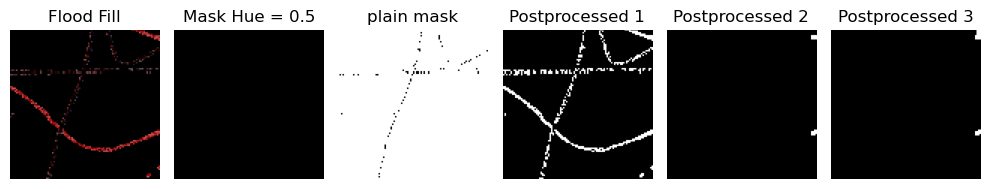

In [76]:
img1, img2, img3, img4, img5, img6, img7 = mask_flood_fill(masked_image,seed=(58, 24), tolerance=0.5)

plot_images(color.hsv2rgb(img1), img3,img7, img4, img5, img6, titles=['Flood Fill',  'Mask Hue = 0.5','plain mask', 'Postprocessed 1', 'Postprocessed 2', 'Postprocessed 3'], height=10)

In [119]:
masked_image = mask_image(image_rgb)

(2261, 3099, 3)


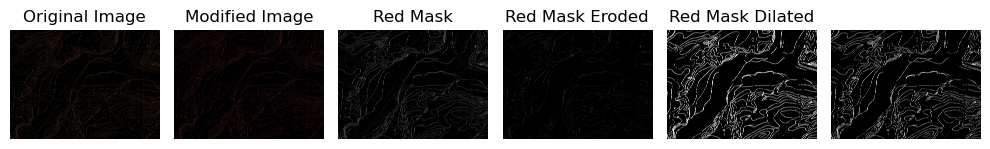

In [120]:
img_test = color.rgb2hsv(masked_image)
img_test_copy = np.copy(img_test)
# flood function returns a mask of flooded pixels
mask = flood(img_test[..., 0], (58, 24), tolerance=0.5)
# Set pixels of mask to new value for hue channel
img_test[mask, 0] = 0

print(img_test.shape)

# Create a mask for red hue values: low red and high red
low_red_mask = img_test[..., 2] > 0.4

# Combine both masks to capture all red pixels (low and high red hues)
red_mask = low_red_mask 

# erode
kernel = np.ones((2,2),np.uint8)
kernel2 = np.ones((5,5),np.uint8)
kernel3 = np.ones((3,3),np.uint8)
kernel4 = np.ones((7,7),np.uint8)
red_mask_eroded = cv2.erode(red_mask.astype(np.uint8), kernel, iterations=1)
red_mask_dilated = cv2.dilate(red_mask_eroded, kernel3, iterations=3)
red_mask_eroded_2 = cv2.erode(red_mask_dilated, kernel3, iterations=1)


image_test_rgb = color.hsv2rgb(img_test)

# Plot the original, modified, and red mask images
plot_images(masked_image, image_test_rgb, red_mask, red_mask_eroded,red_mask_dilated,red_mask_eroded_2, titles=['Original Image', 'Modified Image', 'Red Mask', 'Red Mask Eroded','Red Mask Dilated'], height=10)


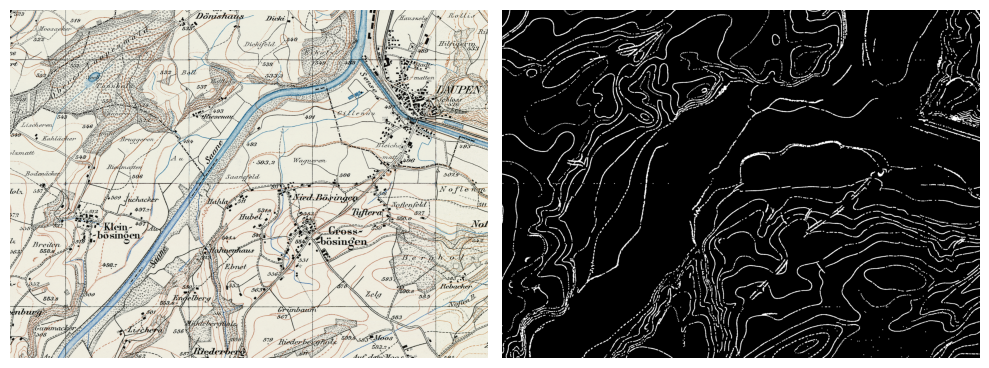

In [123]:
plot_images(image_rgb,red_mask_eroded_2)